## Set up Dataset

In [5]:
import datasets as datasets
import models as models
import losses as losses
import utils
import config as cf
import torch

import pickle
import os

config = cf.read_json("../experiments/exp_r4_linear_output/quad_default/config.json")
config['exp_dir'] = os.path.join(config["trainer"]["base_exp_dir"], config["model_name"])
torch.cuda.set_device(config['device_num'])

# Load Train Dataset
if "precomputed_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["precomputed_train"], "rb"))
elif "save_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["save_train"], "rb"))
else:
    train_dataset = cf.initialize_from_config(config, 'dataset', datasets)

#if "precomputed_val" in config['dataset']:
#    val_dataset = pickle.load(open(config['dataset']["precomputed_val"], "rb"))
#elif "save_val" in config['dataset']:
#    val_dataset = pickle.load(open(config['dataset']["save_val"], "rb"))
#else:
val_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="test")

train_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, train_dataset, shuffle=True)
val_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, val_dataset)

# Wrappers for embedding evaluation
ge_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, train_dataset)
ge_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, val_dataset)
smiles_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, train_dataset)
smiles_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, val_dataset)

uniq_train_perts = set(smiles_wrapper_train.pert_smiles)
uniq_val_perts = set(smiles_wrapper_val.pert_smiles)

ge_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_train)
ge_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_val)
smiles_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_train)
smiles_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_val)

### Load Model

In [8]:
import torch
import torch.nn as nn
import sys

model = torch.load("../experiments/exp_r4_linear_output/quad_default/checkpoint_quad_default_92_val_mrr=0.09293122.pth")

In [9]:
chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/repo/chemprop/pcba/model_unoptimized.pt")

In [10]:
import numpy as np

def get_embeddings(model, ge_wrapper, ge_loader, smiles_wrapper, smiles_loader):
    gex_raw = np.zeros([ge_wrapper.__len__(), ge_wrapper.__getitem__(0)[0].shape[0]])
    gex_embeddings = np.zeros([ge_wrapper.__len__(), model.embed_size])
    smiles_gex_labels = []
    smiles_chem_labels = []
    chem_embeddings = np.zeros([smiles_wrapper.__len__(), model.embed_size])
    
    if 'rdkit_features' in config and config['rdkit_features']:
        nfeats_chemprop = 2400
    else:
        nfeats_chemprop = 300
    chem_embeddings_chemprop = np.zeros([smiles_wrapper.__len__(), nfeats_chemprop])
    # smiles_strings = smiles_wrapper.pert_smiles

    model.eval()
    with torch.no_grad():
        # GE embeds for all of train
        for i, batch in enumerate(ge_loader):
            gex = batch[0].cuda()
            start_ind = i * ge_loader.batch_size
            end_ind = start_ind + gex.shape[0]

            smiles_gex_labels.extend(batch[1])
            gex_embeddings[start_ind:end_ind, :] = model.ge_embed(gex).cpu().numpy()
            gex_raw[start_ind:end_ind, :] = gex.cpu().numpy()

        # Embeds for all unique chems
        for i, batch in enumerate(smiles_loader):
            smiles = batch
            smiles_chem_labels.extend(batch)
            start_ind = i * smiles_loader.batch_size
            end_ind = start_ind + len(smiles)
            if 'rdkit_features' in config and config['rdkit_features']:
                feats = [smiles_to_feats[x] for x in smiles]
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles, feats))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles, feats)
            else:
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles)
            chem_embeddings[start_ind:end_ind, :] = chem_embeds.cpu().numpy()
            chem_embeddings_chemprop[start_ind:end_ind, :] = chem_embeds_chemprop.cpu().numpy()
            
    # Embeddings for all chems in train
    smile_to_chem = {}
    smile_to_chem_cp = {}
    for i, smile in enumerate(smiles_chem_labels):
        smile_to_chem[smile] = chem_embeddings[i,:]
        smile_to_chem_cp[smile] = chem_embeddings_chemprop[i,:]

    chem_embeddings_all = []
    chem_embeddings_all_chemprop = []
    for smile in smiles_gex_labels:
        chem_embeddings_all.append(smile_to_chem[smile])
        chem_embeddings_all_chemprop.append(smile_to_chem_cp[smile])
    chem_embeddings_all = np.stack(chem_embeddings_all)
    chem_embeddings_all_chemprop = np.stack(chem_embeddings_all_chemprop)

    return gex_raw, gex_embeddings, chem_embeddings_all, chem_embeddings_all_chemprop, np.array(smiles_gex_labels), np.array(smiles_chem_labels)

In [11]:
gex_raw, gex_embeddings, chem_embeddings, chem_embeddings_chemprop, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_chemprop.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((5069, 2934), (5069, 128), (5069, 128), (5069, 300), 5069, 3370)

In [12]:
gex_raw_train, gex_embeddings_train, chem_embeddings_train, chem_embeddings_chemprop_train, smiles_gex_labels_train, smiles_chem_labels_train = get_embeddings(model, ge_wrapper_train, ge_loader_train, smiles_wrapper_train, smiles_loader_train)
gex_raw_train.shape, gex_embeddings_train.shape, chem_embeddings_train.shape, chem_embeddings_chemprop_train.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)

((29548, 2934), (29548, 128), (29548, 128), (29548, 300), 29548, 6318)

# Distance Computations

## Model space

In [7]:
from scipy.spatial.distance import cdist
gex_chem_embed_dist = cdist(gex_embeddings_mean_pd, chem_embeddings_mean_pd,  metric='correlation')

gex_chem_dists = gex_chem_embed_dist[np.triu_indices(2248, k=1)]

gex_chem_embed_dist.shape, len(gex_chem_dists)

NameError: name 'gex_embeddings_mean_pd' is not defined

In [ ]:
import seaborn as sns
sns.distplot(gex_chem_embed_dist.diagonal())
sns.distplot(gex_chem_embed_dist[np.triu_indices(2248, k=1)])

In [ ]:
print("Average correlation between matched GE and Chem embeds:   ", np.mean(1 - gex_chem_embed_dist.diagonal()))
print("Average correlation between unmatched GE and Chem embeds: ", np.mean(1 - gex_chem_embed_dist[np.triu_indices(2248, k=1)]))


## Tanimoto similarity

In [13]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles,AllChem
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]

In [14]:
inds = np.triu_indices(2248, k=1)
tanimoto_dists = [1 - DataStructs.FingerprintSimilarity(fps[inds[0][i]],
                                   fps[inds[1][i]])
 for i in range( len(inds[0]) )
]

In [15]:
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fingerprints = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms_train = [MolFromSmiles(x) for x in smiles_gex_labels_train]
fingerprints_train = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms_train])

fingerprints.shape, fingerprints_train.shape

((5069, 128), (29548, 128))

## GE similarity 

In [ ]:
gex_raw_pd = pd.DataFrame(data=gex_raw[:,-978:], index = smiles_gex_labels).rename_axis(index=['smiles'])
gex_raw_train_pd = pd.DataFrame(data=gex_raw_train[:,-978:], index = smiles_gex_labels_train).rename_axis(index=['smiles'])

In [ ]:
average_ges = gex_raw_pd.groupby('smiles').mean()
ge_dists = cdist(average_ges,average_ges, "correlation")[np.triu_indices(2248,k=1)]

In [ ]:
len(tanimoto_dists),len(gex_chem_dists),len(ge_dists)

## Correlations of Distances

In [ ]:
(np.corrcoef(tanimoto_dists, ge_dists)[0,1],
 np.corrcoef(tanimoto_dists, gex_chem_dists)[0,1],
 np.corrcoef(gex_chem_dists, ge_dists)[0,1])

In [ ]:
all_sims = 1 - pd.DataFrame({'Tanimoto':tanimoto_dists,
                              'GE':ge_dists,
                              'Model':gex_chem_dists
                             })
all_sims.head(20)

In [ ]:
sns.scatterplot(x="Tanimoto", y="GE",
                hue='Model',
                data = all_sims.sample(500))

## Ranking results

In [16]:
from scipy.stats.mstats import rankdata
import seaborn as sns

def get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels):
    rank_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        matches = np.where(smiles_chem_labels == sml)[0]
        ranks_matches = gex_chem_ranks[i, matches]
        rank_first_match.append(np.min(ranks_matches))
    rank_first_match = np.array(rank_first_match).squeeze()
    return rank_first_match

def prepare_metrics(rank_first_match, indices):
    median_rank = np.median(rank_first_match[indices])
    mrr = np.mean(1 / rank_first_match[indices])
    hits_at_10 = np.mean(
        [np.sum(results <= 10) for results in rank_first_match[indices]])  # can change to rank_all_matches
    hits_at_100 = np.mean([np.sum(results <= 100) for results in rank_first_match[indices]])
    hits_at_500 = np.mean([np.sum(results <= 500) for results in rank_first_match[indices]])
    return {#"total_drugs": len(set(np.array(smiles_gex_labels)[inds])),
            "median_rank": median_rank,
            "MRR": mrr,
            "H@10": hits_at_10,
            "H@100": hits_at_100,
            "H@500": hits_at_500
        }

def get_val_scores(distmat, smiles_gex_labels=smiles_gex_labels, smiles_chem_labels=smiles_gex_labels,
                   train_smiles = list(set(smiles_chem_labels_train))):

    gex_chem_ranks = rankdata(distmat, axis=1)

    rank_first_match_all = get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels)

    list_of_inds = [[i for i,j in enumerate(smiles_gex_labels)]]
    ge_inds_in_train = [i for i, j in enumerate(smiles_gex_labels) if j in train_smiles]
    ge_inds_not_in_train = [i for i, j in enumerate(smiles_gex_labels) if j not in train_smiles]
    list_of_inds.append(ge_inds_in_train)
    list_of_inds.append(ge_inds_not_in_train)

    chem_inds_not_in_train = [i for i,j in enumerate(smiles_chem_labels) if j not in train_smiles]

    ir_results = []
    for inds in list_of_inds:
        ir_results.append(prepare_metrics(rank_first_match_all, inds))

    ranks_subset = rankdata(gex_chem_ranks[:, chem_inds_not_in_train][ge_inds_not_in_train,:], axis=1)
    rank_first_match = get_ranks_first_match(ranks_subset,
                                             smiles_gex_labels[ge_inds_not_in_train],
                                             smiles_chem_labels[chem_inds_not_in_train])
    ir_results.append(prepare_metrics(rank_first_match,
                                      [k for k in range(len(ge_inds_not_in_train))]
                                      ))
    val_print_labels = ["Val (All):              ", "Val (In Train):         ",
                            "Val (Not in Train):     ", "Val (No train, limited):"]
    for i, res_dict in enumerate(ir_results):
        print(val_print_labels[i] + "    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

        
    return rank_first_match_all, rank_first_match

from sklearn.cross_decomposition import CCA
def cca_cor(ncomp = 50,
            embeds_ge_train=gex_embeddings_train, embeds_chem_train=chem_embeddings_train,
            embeds_ge_val=gex_embeddings, embeds_chem_val=chem_embeddings ):
    print("CCA w/", ncomp, "components")
    cca = CCA(n_components=ncomp, max_iter = 1000)
    cca.fit(embeds_ge_train, embeds_chem_train)
    cca_gex_val, cca_chem_val = cca.transform(embeds_ge_val, embeds_chem_val)

    print("Computing Distances")
    gex_chem_embed_dist_cca = cdist(cca_gex_val, cca_chem_val,  metric='correlation')
    ranks_val_all, ranks_val_out = get_val_scores(gex_chem_embed_dist_cca)

    print("Average correlation between matched GE and Chem embeds (CCA):   ", np.mean(1 - gex_chem_embed_dist_cca.diagonal()))
    print("Average correlation between unmatched GE and Chem embeds (CAA): ", np.mean(1 - gex_chem_embed_dist_cca[np.triu_indices(gex_chem_embed_dist_cca.shape[0], k=1)]))
    print("Difference: ", np.mean(1 - gex_chem_embed_dist_cca.diagonal()) - np.mean(1 - gex_chem_embed_dist_cca[np.triu_indices(gex_chem_embed_dist_cca.shape[0], k=1)]) )
    print()
    
    sns.distplot(1-gex_chem_embed_dist_cca.diagonal())
    sns.distplot(1-gex_chem_embed_dist_cca[np.triu_indices(gex_chem_embed_dist_cca.shape[0], k=1)])
    return ranks_val_all, ranks_val_out

## Do CCA 

In [17]:
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((5069, 2934), (5069, 128), (5069, 128), 5069, 3370)

In [20]:
from scipy.spatial.distance import cdist
gex_chem_baseline_dist = cdist(gex_embeddings, chem_embeddings,  metric='correlation')

In [21]:
print("Original")
ranks_val_orig_all, ranks_val_orig_out = get_val_scores(gex_chem_baseline_dist,
                                                       smiles_chem_labels = smiles_gex_labels)

Original
Val (All):              median_rank: 303.000    MRR: 0.045    H@10: 0.095    H@100: 0.306    H@500: 0.621
Val (In Train):         median_rank: 232.500    MRR: 0.052    H@10: 0.110    H@100: 0.346    H@500: 0.681
Val (Not in Train):     median_rank: 929.250    MRR: 0.010    H@10: 0.026    H@100: 0.121    H@500: 0.345
Val (No train, limited):median_rank: 270.500    MRR: 0.025    H@10: 0.056    H@100: 0.273    H@500: 0.702


CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 1623.000    MRR: 0.020    H@10: 0.050    H@100: 0.129    H@500: 0.268
Val (In Train):         median_rank: 1510.500    MRR: 0.023    H@10: 0.059    H@100: 0.150    H@500: 0.292
Val (Not in Train):     median_rank: 2031.000    MRR: 0.004    H@10: 0.009    H@100: 0.036    H@500: 0.162
Val (No train, limited):median_rank: 383.500    MRR: 0.014    H@10: 0.024    H@100: 0.171    H@500: 0.620
Average correlation between matched GE and Chem embeds (CCA):    0.09802374124912341
Average correlation between unmatched GE and Chem embeds (CAA):  -0.0017253095057357547
Difference:  0.09974905075485917



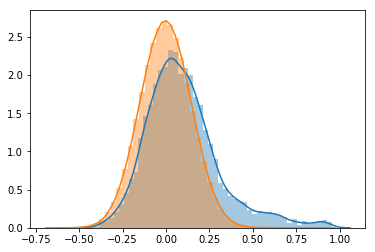

In [25]:
ranks_val_rawGE_fps_all, ranks_val_rawGE_fps_out = cca_cor(ncomp = 50,
        embeds_ge_train=gex_raw_train[:,-978:], embeds_chem_train=fingerprints_train,
        embeds_ge_val=gex_raw[:,-978:], embeds_chem_val=fingerprints)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 1284.000    MRR: 0.027    H@10: 0.063    H@100: 0.174    H@500: 0.326
Val (In Train):         median_rank: 1230.000    MRR: 0.031    H@10: 0.074    H@100: 0.191    H@500: 0.343
Val (Not in Train):     median_rank: 1501.000    MRR: 0.006    H@10: 0.014    H@100: 0.095    H@500: 0.251
Val (No train, limited):median_rank: 301.750    MRR: 0.023    H@10: 0.050    H@100: 0.236    H@500: 0.678
Average correlation between matched GE and Chem embeds (CCA):    0.13514376572170428
Average correlation between unmatched GE and Chem embeds (CAA):  -0.0003040638786608848
Difference:  0.13544782960036517



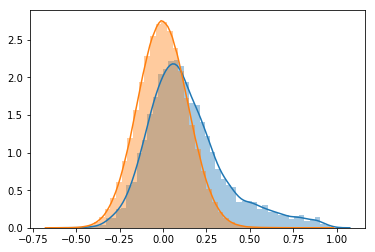

In [26]:
ranks_val_rawGE_chemprop_all, ranks_val_rawGE_chemprop_out = cca_cor(ncomp = 50,
                                                                       embeds_ge_train=gex_raw_train[:,-978:],
                                                                       embeds_ge_val=gex_raw[:,-978:],
                                                                       embeds_chem_train=chem_embeddings_chemprop_train,
                                                                       embeds_chem_val=chem_embeddings_chemprop)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 899.500    MRR: 0.033    H@10: 0.077    H@100: 0.212    H@500: 0.398
Val (In Train):         median_rank: 785.000    MRR: 0.038    H@10: 0.089    H@100: 0.235    H@500: 0.423
Val (Not in Train):     median_rank: 1328.750    MRR: 0.009    H@10: 0.021    H@100: 0.105    H@500: 0.283
Val (No train, limited):median_rank: 286.500    MRR: 0.029    H@10: 0.057    H@100: 0.267    H@500: 0.727
Average correlation between matched GE and Chem embeds (CCA):    0.1783892406688952
Average correlation between unmatched GE and Chem embeds (CAA):  -0.0013232973029831008
Difference:  0.1797125379718783



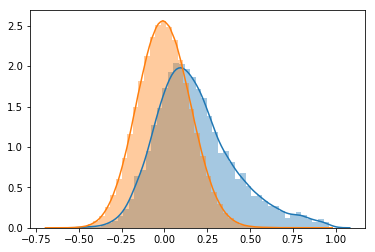

In [27]:
ranks_val_rawGE_chemEmbed_all, ranks_val_rawGE_chemEmbed_out = cca_cor(ncomp = 50,
        embeds_ge_train=gex_raw_train[:,-978:],
        embeds_ge_val=gex_raw[:,-978:])

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 1004.000    MRR: 0.018    H@10: 0.047    H@100: 0.166    H@500: 0.367
Val (In Train):         median_rank: 803.500    MRR: 0.021    H@10: 0.055    H@100: 0.191    H@500: 0.410
Val (Not in Train):     median_rank: 1910.500    MRR: 0.005    H@10: 0.010    H@100: 0.047    H@500: 0.173
Val (No train, limited):median_rank: 384.000    MRR: 0.015    H@10: 0.028    H@100: 0.173    H@500: 0.637
Average correlation between matched GE and Chem embeds (CCA):    0.17084957645350443
Average correlation between unmatched GE and Chem embeds (CAA):  0.006944779054960215
Difference:  0.16390479739854422



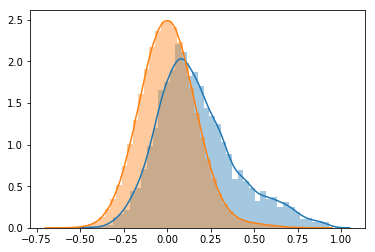

In [24]:
ranks_val_geEmbed_fps_all, ranks_val_geEmbed_fps_out = cca_cor(ncomp = 50,
                                                               embeds_chem_train=fingerprints_train,
                                                               embeds_chem_val=fingerprints)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 626.000    MRR: 0.028    H@10: 0.065    H@100: 0.217    H@500: 0.456
Val (In Train):         median_rank: 493.000    MRR: 0.033    H@10: 0.077    H@100: 0.251    H@500: 0.502
Val (Not in Train):     median_rank: 1391.000    MRR: 0.004    H@10: 0.010    H@100: 0.060    H@500: 0.246
Val (No train, limited):median_rank: 286.250    MRR: 0.018    H@10: 0.031    H@100: 0.233    H@500: 0.717
Average correlation between matched GE and Chem embeds (CCA):    0.22872490246829463
Average correlation between unmatched GE and Chem embeds (CAA):  0.009804322959187416
Difference:  0.2189205795091072



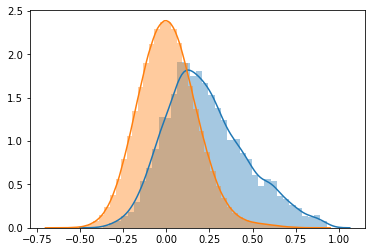

In [23]:
ranks_val_geEmbed_chemprop_all, ranks_val_geEmbed_chemprop_out = cca_cor(ncomp = 50,
                                                               embeds_chem_train=chem_embeddings_chemprop_train,
                                                               embeds_chem_val=chem_embeddings_chemprop)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 298.500    MRR: 0.049    H@10: 0.106    H@100: 0.316    H@500: 0.613
Val (In Train):         median_rank: 227.000    MRR: 0.058    H@10: 0.124    H@100: 0.362    H@500: 0.673
Val (Not in Train):     median_rank: 929.000    MRR: 0.010    H@10: 0.025    H@100: 0.106    H@500: 0.338
Val (No train, limited):median_rank: 270.500    MRR: 0.025    H@10: 0.051    H@100: 0.281    H@500: 0.710
Average correlation between matched GE and Chem embeds (CCA):    0.4632015523292113
Average correlation between unmatched GE and Chem embeds (CAA):  0.03998784646605667
Difference:  0.4232137058631546



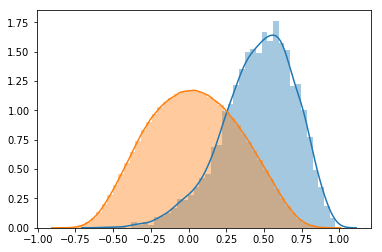

In [22]:
ranks_val_cca_all, ranks_val_cca_out = cca_cor(50)

## Plots

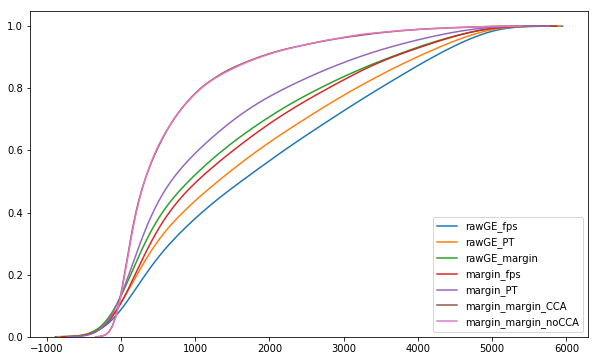

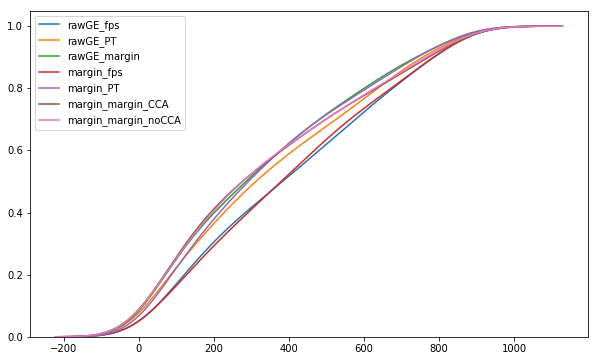

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.kdeplot(ranks_val_rawGE_fps_all, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_all, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_all, cumulative=True, label = 'rawGE_margin')
sns.kdeplot(ranks_val_geEmbed_fps_all, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_all, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_all, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_all, cumulative=True, label = "margin_margin_noCCA")
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.kdeplot(ranks_val_rawGE_fps_out, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_out, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_out, cumulative=True, label = 'rawGE_margin')
sns.kdeplot(ranks_geEmbed_fps_out, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_out, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_out, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_out, cumulative=True, label = "margin_margin_noCCA")
plt.show()